In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import numpy as np

In [2]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/utkarshgoyal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df_spam = pd.read_csv(r'spam.csv')
df_spam['spam']=df_spam['Category'].apply(lambda x: 1 if x=='spam' else 0)

df_spam.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


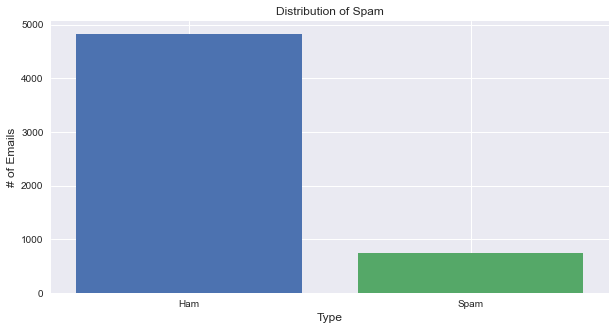

In [4]:
plt.figure(figsize=(10, 5))
plt.bar('Ham', len(df_spam[df_spam['Category']=='ham']))
plt.bar('Spam', len(df_spam[df_spam['Category']=='spam']))

plt.title('Distribution of Spam', size=12)
plt.xlabel('Type', size=12)
plt.ylabel('# of Emails', size=12);

In [5]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    
import re

def normalize(i):
#     for i in data:
    i = i.lower()
    # get rid of urls
    i = re.sub('https?://\S+|www\.\S+', '', i)

    i = re.sub('<[^>]*>', '', i)
    i = re.sub(r'[^\w\s]','', i)
    i = re.sub(r'\$\w*','', i)
    i = re.sub(r'^RT[\s]+','', i)
    i = re.sub(r'http\S+','', i)
    i = re.sub(r'#','', i)

    # get rid of non words and extra spaces
    i = re.sub('\\W', ' ', i)
    i = re.sub('\n', '', i)
    i = re.sub(' +', ' ', i)
    i = re.sub('^ ', '', i)
    i = re.sub(' $', '', i)
    
    return i

In [6]:
# df_spam.Message = df_spam.Message.apply(remove_stopwords)
# df_spam.Message = df_spam.Message.apply(normalize)
df_spam.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [7]:
X = df_spam['Message']
y = df_spam['spam']

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

In [9]:
vocab_size = 100000
embedding_dim = 64
max_length = 128
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [10]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2")

In [11]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

# Build Model

## NN

In [13]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
hidden1 = tf.keras.layers.Dense(64, activation='sigmoid')(outputs['pooled_output'])
dropout1 = tf.keras.layers.Dropout(0.1, name="dropout")(hidden1)
hidden2 = tf.keras.layers.Dense(32, activation='sigmoid')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.1, name="dropout2")(hidden2)
hidden3 = tf.keras.layers.Dense(16, activation='sigmoid')(dropout2)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(hidden3)

# l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
# l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(optimizer='adam',  loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
134/134 [==============================] - 18s 113ms/step - loss: 0.4286 - accuracy: 0.8534 - val_loss: 0.3305 - val_accuracy: 0.8901
Epoch 2/10
134/134 [==============================] - 14s 108ms/step - loss: 0.2806 - accuracy: 0.8823 - val_loss: 0.1918 - val_accuracy: 0.9484
Epoch 3/10
134/134 [==============================] - 15s 113ms/step - loss: 0.1540 - accuracy: 0.9634 - val_loss: 0.1407 - val_accuracy: 0.9619
Epoch 4/10
134/134 [==============================] - 15s 109ms/step - loss: 0.1137 - accuracy: 0.9703 - val_loss: 0.1428 - val_accuracy: 0.9529
Epoch 5/10
134/134 [==============================] - 15s 112ms/step - loss: 0.1043 - accuracy: 0.9683 - val_loss: 0.1482 - val_accuracy: 0.9462


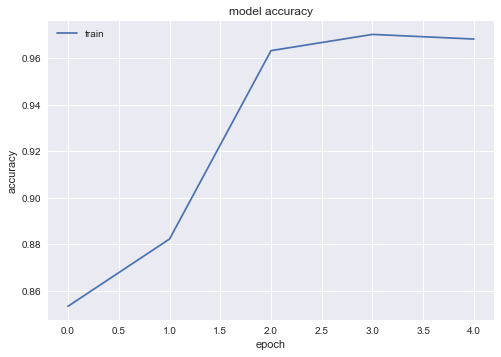

In [17]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

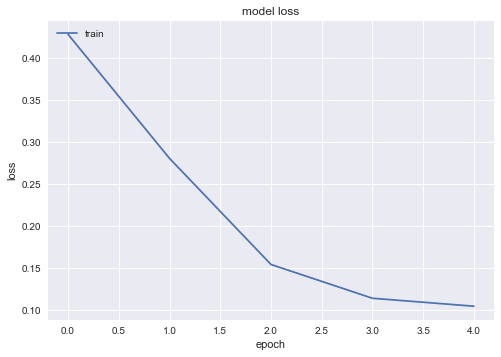

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

35/35 [==============================] - 4s 97ms/step


---Test Set Results---
Accuracy: 0.9525


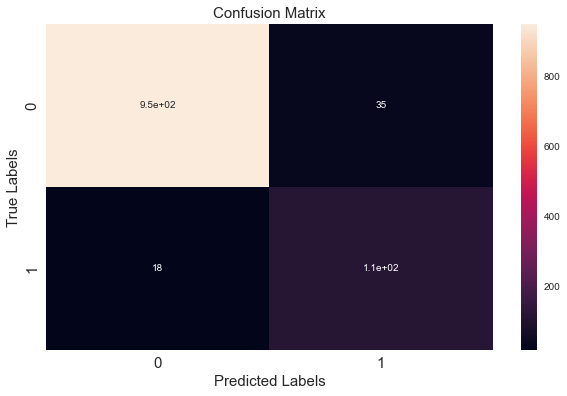

In [23]:
import seaborn as sns
print("---Test Set Results---")
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

print("Accuracy: {:.4f}".format(accuracy_score(y_test, binary_predictions)))

## LSTM

In [42]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
# embed1 = tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length)()
hidden1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True))(outputs['sequence_output'])
dropout1 = tf.keras.layers.Dropout(0.1, name="dropout")(hidden1)
hidden2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(dropout1)
dropout2 = tf.keras.layers.Dropout(0.1, name="dropout2")(hidden2)
hidden3 = tf.keras.layers.Dense(16, activation='sigmoid')(dropout2)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(hidden3)


# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [43]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy')]
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=METRICS)

In [44]:
history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
134/134 [==============================] - 36s 221ms/step - loss: 0.5450 - accuracy: 0.7529 - val_loss: 0.3673 - val_accuracy: 0.9103
Epoch 2/10
134/134 [==============================] - 31s 231ms/step - loss: 0.2933 - accuracy: 0.9696 - val_loss: 0.2500 - val_accuracy: 0.9709
Epoch 3/10
134/134 [==============================] - 28s 212ms/step - loss: 0.2208 - accuracy: 0.9791 - val_loss: 0.2151 - val_accuracy: 0.9709
Epoch 4/10
134/134 [==============================] - 29s 213ms/step - loss: 0.1907 - accuracy: 0.9818 - val_loss: 0.1902 - val_accuracy: 0.9776
Epoch 5/10
134/134 [==============================] - 28s 211ms/step - loss: 0.1696 - accuracy: 0.9853 - val_loss: 0.1809 - val_accuracy: 0.9731
Epoch 6/10
134/134 [==============================] - 30s 221ms/step - loss: 0.1552 - accuracy: 0.9868 - val_loss: 0.1621 - val_accuracy: 0.9798
Epoch 7/10
134/134 [==============================] - 28s 207ms/step - loss: 0.1403 - accuracy: 0.9878 - val_loss: 0.1596 - val_ac

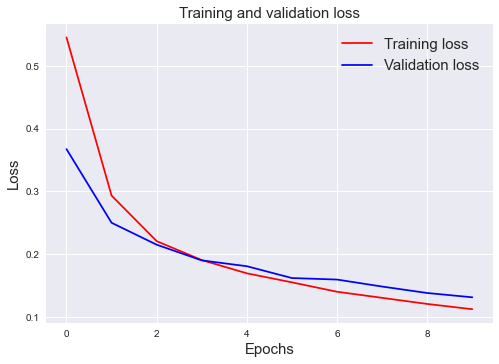

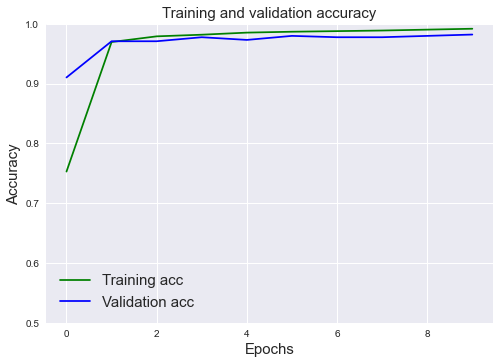

In [45]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

In [46]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)



35/35 [==============================] - 6s 128ms/step


---Test Set Results---
Accuracy: 0.9794


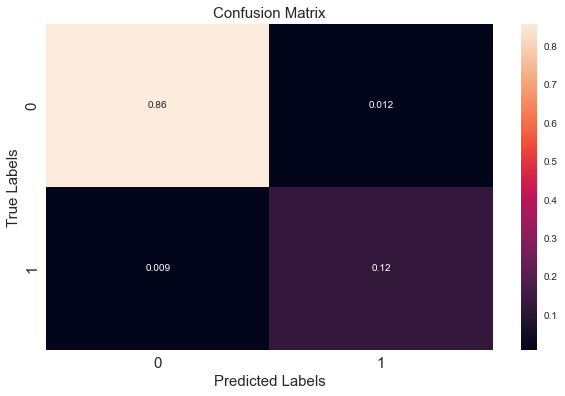

In [48]:
import seaborn as sns
print("---Test Set Results---")
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

print("Accuracy: {:.4f}".format(accuracy_score(y_test, binary_predictions)))